In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# 1. Pick a stock of your choice
stock_symbol = "AMZN"

# 2. Retrieve historical stock data
stock_data = yf.download(stock_symbol, start="2023-01-01", end="2024-01-01")
print("Historical Stock Data:")
stock_data.tail()

[*********************100%%**********************]  1 of 1 completed

Historical Stock Data:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000
2023-12-29,153.100006,153.889999,151.029999,151.940002,151.940002,39789000


In [3]:
# Function to fetch historical stock data
def fetch_stock_history(ticker):
    stock = yf.Ticker(ticker)
    historical_data = stock.history(period="max")
    return historical_data

# Function to fetch historical options data
def fetch_option_history(ticker):
    option = yf.Ticker(ticker)
    options_data = option.options
    return options_data


# Stock ticker
stock_ticker = "AMZN"

# Fetch historical options data
option_history = fetch_option_history(stock_ticker)
print("\nHistorical Options Data for", stock_ticker)
print(option_history)  # Displaying historical options data


Historical Options Data for AMZN
('2024-04-26', '2024-05-03', '2024-05-10', '2024-05-17', '2024-05-24', '2024-05-31', '2024-06-21', '2024-07-19', '2024-08-16', '2024-09-20', '2024-10-18', '2024-11-15', '2024-12-20', '2025-01-17', '2025-03-21', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18')


In [4]:
# 3. Retrieve historical option data
option_data = yf.Ticker(stock_symbol)
options = option_data.options
if len(options) > 0:
    option_exp_date = option_history [0]  # You can choose any expiration date here
    option_chain = option_data.option_chain(option_exp_date)
    print("\nOption Chain for", stock_symbol, "with expiration date", option_exp_date)
    print(option_chain.calls.head(5))
else:
    print("\nNo options data available for", stock_symbol)


Option Chain for AMZN with expiration date 2024-04-26
        contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0  AMZN240426C00095000 2024-04-19 17:14:02+00:00    95.0      79.78  79.25   
1  AMZN240426C00100000 2024-04-19 14:26:14+00:00   100.0      76.35  74.30   
2  AMZN240426C00105000 2024-04-19 19:56:30+00:00   105.0      69.87  69.25   
3  AMZN240426C00110000 2024-04-16 15:28:26+00:00   110.0      74.65  64.30   
4  AMZN240426C00115000 2024-04-19 17:57:42+00:00   115.0      60.75  59.25   

    ask     change  percentChange  volume  openInterest  impliedVolatility  \
0  80.2  79.780000            NaN     1.0             1           1.996094   
1  75.2  -6.020004      -7.308491    40.0            12           1.898438   
2  70.2  -8.790001     -11.174677     1.0             3           1.695314   
3  65.2   0.000000       0.000000     2.0             8           1.601564   
4  60.2  -8.860001     -12.728058     3.0            57           1.417972   

   inTh

In [5]:
market_data_call = [6.30,4.55, 3.1,2.03,1.24]
market_data_put= [1.52, 2.28, 3.30, 4.70, 6.51]

In [6]:
# Estimate annual volatility using past one-year data

historical_prices = stock_data['Adj Close']
returns = historical_prices.pct_change().dropna()
volatility = np.sqrt(252) * returns.std()  # Assuming 252 trading days in a year
print("\nEstimated Annual Volatility:", volatility)


Estimated Annual Volatility: 0.3302668231225627


In [7]:
# Use 10 years’ US treasury rate as the rate of interest

us_treasury_rate = 0.046  # Assume a 10-year US Treasury rate of 4.6
r = us_treasury_rate
sigma = volatility

In [8]:
def binomial_option_price(S, K, T, r, sigma, option_type='call', steps=3):

    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    prices = np.zeros(steps + 1)
    for i in range(steps + 1):
        prices[i] = S * (u ** (steps - i)) * (d ** i)

    option_values = np.zeros(steps + 1)
    if option_type == 'call':
        option_values = np.maximum(0, prices - K)
    elif option_type == 'put':
        option_values = np.maximum(0, K - prices)

    for j in range(steps):
        option_values = np.exp(-r * dt) * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]


stock_price = 173.85 # Current price of the underlying asset
strike_prices = [170, 172.5, 175, 177.5, 180] # different strike price
expiration_dates = [0.0277, 0.0555]  # Expiration dates in days
risk_free_rate = r  # Risk-free interest rate
volatility = sigma  # Volatility of the underlying asset
option_prices_c = []

for expiration_date in expiration_dates:
    print(f"\nCall Option prices for expiration date {expiration_date} days:")
    for strike_price in strike_prices:
        option_price_c = binomial_option_price(stock_price, strike_price, expiration_date, risk_free_rate, volatility)
        option_prices_c.append(option_price_c)  # Store the option price in the list
        print(f"Strike Price: {strike_price}, Option Price: {option_price_c:.2f}")



Call Option prices for expiration date 0.0277 days:
Strike Price: 170, Option Price: 6.16
Strike Price: 172.5, Option Price: 4.92
Strike Price: 175, Option Price: 3.67
Strike Price: 177.5, Option Price: 2.43
Strike Price: 180, Option Price: 1.39

Call Option prices for expiration date 0.0555 days:
Strike Price: 170, Option Price: 7.98
Strike Price: 172.5, Option Price: 6.74
Strike Price: 175, Option Price: 5.50
Strike Price: 177.5, Option Price: 4.26
Strike Price: 180, Option Price: 3.02


In [9]:
def binomial_option_price(S, K, T, r, sigma, option_type='put', steps=3):
    """
    For put option
    """
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    prices = np.zeros(steps + 1)
    for i in range(steps + 1):
        prices[i] = S * (u ** (steps - i)) * (d ** i)

    option_values = np.zeros(steps + 1)
    if option_type == 'call':
        option_values = np.maximum(0, prices - K)
    elif option_type == 'put':
        option_values = np.maximum(0, K - prices)

    for j in range(steps):
        option_values = np.exp(-r * dt) * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

stock_price = 173.85 # Current price of the underlying asset
strike_prices = [170, 172.5, 175, 177.5, 180]  # Different strike prices
expiration_dates = [0.0277, 0.0555]  # Expiration dates in days
risk_free_rate = r  # Risk-free interest rate
volatility = sigma  # Volatility of the underlying asset
option_prices_p = []


for expiration_date in expiration_dates:
    print(f"\nPut Option prices for expiration date {expiration_date} days:")
    for strike_price in strike_prices:
        option_price_p = binomial_option_price(stock_price, strike_price, expiration_date, risk_free_rate, volatility)
        option_prices_p.append(option_price_p)  # Store the option price in the list

        print(f"Strike Price: {strike_price}, Option Price: {option_price_p:.2f}")



Put Option prices for expiration date 0.0277 days:
Strike Price: 170, Option Price: 2.09
Strike Price: 172.5, Option Price: 3.35
Strike Price: 175, Option Price: 4.60
Strike Price: 177.5, Option Price: 5.85
Strike Price: 180, Option Price: 7.31

Put Option prices for expiration date 0.0555 days:
Strike Price: 170, Option Price: 3.70
Strike Price: 172.5, Option Price: 4.95
Strike Price: 175, Option Price: 6.20
Strike Price: 177.5, Option Price: 7.46
Strike Price: 180, Option Price: 8.71


In [10]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

stock_price = 173.85 # Current price of the underlying asset
strike_prices = [170, 172.5, 175, 177.5, 180]# Different strike prices
expiration_dates = [0.0277, 0.0555]  # Expiration dates in days
risk_free_rate = r  # Risk-free interest rate
volatility = sigma  # Volatility of the underlying asset

option_prices_CB = []

for expiration_date in expiration_dates:
    print(f"\nCall Option prices for expiration date {expiration_date} days:")
    for strike_price in strike_prices:
        option_price_CB = black_scholes_call(stock_price, strike_price, expiration_date, risk_free_rate, volatility)
        option_prices_CB.append(option_price_CB)  # Store the option price in the list

        print(f"Strike Price: {strike_price}, Option Price: {option_price_CB:.2f}")


Call Option prices for expiration date 0.0277 days:
Strike Price: 170, Option Price: 6.14
Strike Price: 172.5, Option Price: 4.63
Strike Price: 175, Option Price: 3.38
Strike Price: 177.5, Option Price: 2.38
Strike Price: 180, Option Price: 1.61

Call Option prices for expiration date 0.0555 days:
Strike Price: 170, Option Price: 7.74
Strike Price: 172.5, Option Price: 6.31
Strike Price: 175, Option Price: 5.06
Strike Price: 177.5, Option Price: 3.99
Strike Price: 180, Option Price: 3.10


In [11]:
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

stock_price = 173.85 # Current price of the underlying asset
strike_prices = [170, 172.5, 175, 177.5, 180] # Different strike prices
expiration_dates = [0.0277, 0.0555]  # Expiration dates in days
risk_free_rate = r  # Risk-free interest rate
volatility = sigma  # Volatility of the underlying asset

option_prices_PB = []

for expiration_date in expiration_dates:
    print(f"\nPut Option prices for expiration date {expiration_date} days:")
    for strike_price in strike_prices:
        option_price_PB = black_scholes_put(stock_price, strike_price, expiration_date, risk_free_rate, volatility)
        option_prices_PB.append(option_price_PB)  # Store the option price in the list

        print(f"Strike Price: {strike_price}, Option Price: {option_price_PB:.2f}")


Put Option prices for expiration date 0.0277 days:
Strike Price: 170, Option Price: 2.08
Strike Price: 172.5, Option Price: 3.06
Strike Price: 175, Option Price: 4.30
Strike Price: 177.5, Option Price: 5.80
Strike Price: 180, Option Price: 7.53

Put Option prices for expiration date 0.0555 days:
Strike Price: 170, Option Price: 3.46
Strike Price: 172.5, Option Price: 4.52
Strike Price: 175, Option Price: 5.77
Strike Price: 177.5, Option Price: 7.19
Strike Price: 180, Option Price: 8.79


In [12]:
def binomial_option_price(S, K, T, r, sigma, option_type='call', steps=10):

    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    prices = np.zeros(steps + 1)
    for i in range(steps + 1):
        prices[i] = S * (u ** (steps - i)) * (d ** i)

    option_values = np.zeros(steps + 1)
    if option_type == 'call':
        option_values = np.maximum(0, prices - K)
    elif option_type == 'put':
        option_values = np.maximum(0, K - prices)

    for j in range(steps):
        option_values = np.exp(-r * dt) * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]


stock_price = 173.85 # Current price of the underlying asset
strike_prices = [170, 172.5, 175, 177.5, 180]  # Different strike prices
expiration_dates = [0.0277, 0.0555]  # Expiration dates in days
risk_free_rate = r  # Risk-free interest rate
volatility = sigma  # Volatility of the underlying asset

option_prices_c1 = []


for expiration_date in expiration_dates:
    print(f"\nCall Option prices for expiration date {expiration_date} days:")
    for strike_price in strike_prices:
        option_price_c1 = binomial_option_price(stock_price, strike_price, expiration_date, risk_free_rate, volatility)
        option_prices_c1.append(option_price_c1)  # Store the option price in the list

        print(f"Strike Price: {strike_price}, Option Price: {option_price_c1:.2f}")



Call Option prices for expiration date 0.0277 days:
Strike Price: 170, Option Price: 6.22
Strike Price: 172.5, Option Price: 4.66
Strike Price: 175, Option Price: 3.40
Strike Price: 177.5, Option Price: 2.46
Strike Price: 180, Option Price: 1.52

Call Option prices for expiration date 0.0555 days:
Strike Price: 170, Option Price: 7.86
Strike Price: 172.5, Option Price: 6.32
Strike Price: 175, Option Price: 5.05
Strike Price: 177.5, Option Price: 4.12
Strike Price: 180, Option Price: 3.18


In [13]:
def binomial_option_price(S, K, T, r, sigma, option_type='put', steps=10):

    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    prices = np.zeros(steps + 1)
    for i in range(steps + 1):
        prices[i] = S * (u ** (steps - i)) * (d ** i)

    option_values = np.zeros(steps + 1)
    if option_type == 'call':
        option_values = np.maximum(0, prices - K)
    elif option_type == 'put':
        option_values = np.maximum(0, K - prices)

    for j in range(steps):
        option_values = np.exp(-r * dt) * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

# Example usage:
stock_price = 173.85 # Current price of the underlying asset
strike_prices = [170, 172.5, 175, 177.5, 180]  # Different strike prices
expiration_dates = [0.0277, 0.0555]  # Expiration dates in days
risk_free_rate = r  # Risk-free interest rate
volatility = sigma  # Volatility of the underlying asset
option_prices_p1 = []

for expiration_date in expiration_dates:
    print(f"\nPut Option prices for expiration date {expiration_date} days:")
    for strike_price in strike_prices:
        option_price_p1 = binomial_option_price(stock_price, strike_price, expiration_date, risk_free_rate, volatility)
        option_prices_p1.append(option_price_p1)  # Store the option price in the list

        print(f"Strike Price: {strike_price}, Option Price: {option_price_p1:.2f}")



Put Option prices for expiration date 0.0277 days:
Strike Price: 170, Option Price: 2.15
Strike Price: 172.5, Option Price: 3.10
Strike Price: 175, Option Price: 4.32
Strike Price: 177.5, Option Price: 5.88
Strike Price: 180, Option Price: 7.44

Put Option prices for expiration date 0.0555 days:
Strike Price: 170, Option Price: 3.58
Strike Price: 172.5, Option Price: 4.53
Strike Price: 175, Option Price: 5.75
Strike Price: 177.5, Option Price: 7.31
Strike Price: 180, Option Price: 8.87


In [14]:
option_prices_c = option_prices_c[0:5]
option_prices_c1 = option_prices_c1[0:5]
option_prices_CB = option_prices_CB[0:5]

In [15]:
len(strike_prices)

5

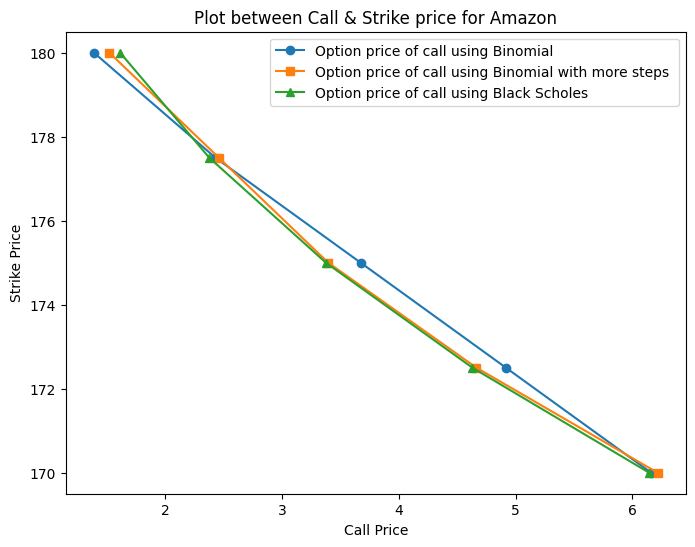

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(option_prices_c, strike_prices, label='Option price of call using Binomial', marker='o')
plt.plot(option_prices_c1, strike_prices, label='Option price of call using Binomial with more steps ', marker='s')
plt.plot(option_prices_CB, strike_prices, label='Option price of call using Black Scholes', marker='^')
plt.xlabel('Call Price')
plt.ylabel('Strike Price')
plt.title('Plot between Call & Strike price for Amazon')
plt.legend()
plt.show()

In [17]:
option_prices_p = option_prices_p[0:5]
option_prices_p1 = option_prices_p1[0:5]
option_prices_PB = option_prices_PB[0:5]

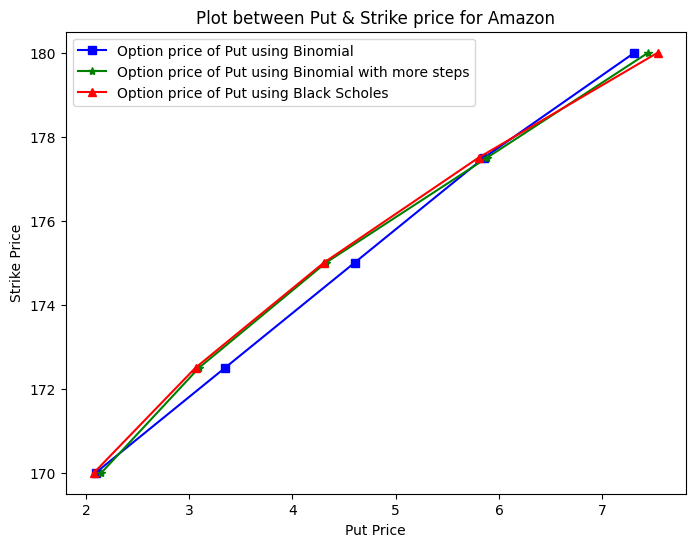

In [18]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(option_prices_p, strike_prices, label='Option price of Put using Binomial', marker='s', color='blue')
plt.plot(option_prices_p1, strike_prices, label='Option price of Put using Binomial with more steps', marker='*', color='green')
plt.plot(option_prices_PB, strike_prices, label='Option price of Put using Black Scholes', marker='^', color='red')
plt.xlabel('Put Price')
plt.ylabel('Strike Price')
plt.title('Plot between Put & Strike price for Amazon')
plt.legend()
plt.show()

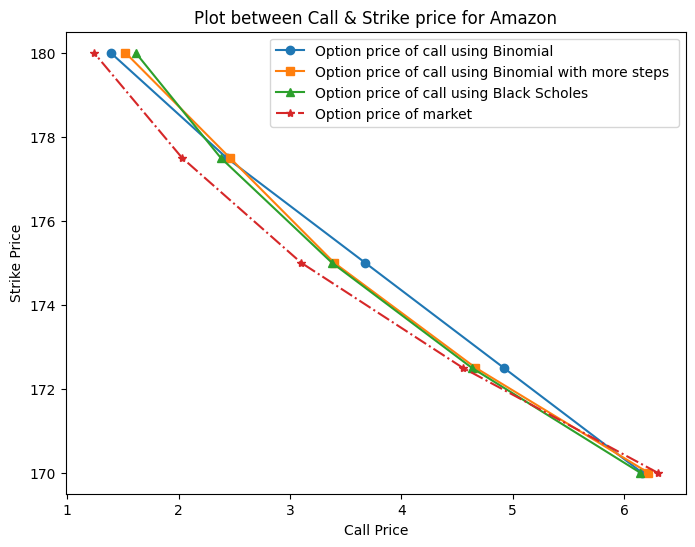

In [19]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(option_prices_c, strike_prices, label='Option price of call using Binomial', marker='o')
plt.plot(option_prices_c1, strike_prices, label='Option price of call using Binomial with more steps ', marker='s')
plt.plot(option_prices_CB, strike_prices, label='Option price of call using Black Scholes', marker='^')
plt.plot(market_data_call, strike_prices, label='Option price of market ', linestyle='-.', marker='*')
plt.xlabel('Call Price')
plt.ylabel('Strike Price')
plt.title('Plot between Call & Strike price for Amazon')
plt.legend()
plt.show()


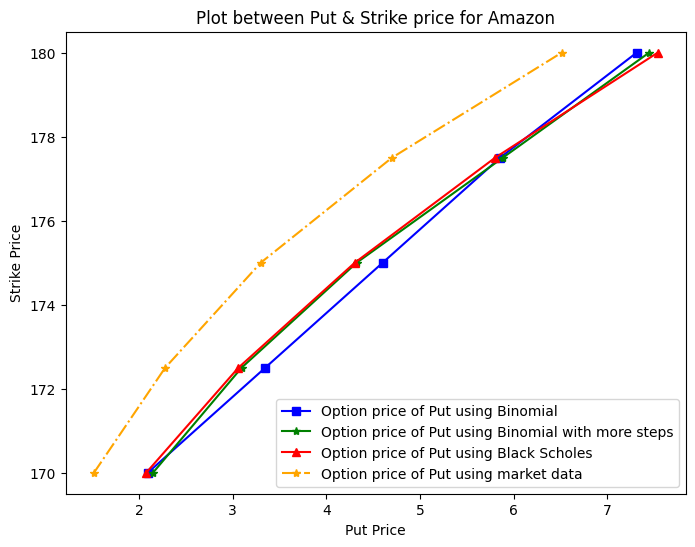

In [20]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(option_prices_p, strike_prices, label='Option price of Put using Binomial',  marker='s', color='blue')
plt.plot(option_prices_p1, strike_prices, label='Option price of Put using Binomial with more steps',  marker='*', color='green')
plt.plot(option_prices_PB, strike_prices, label='Option price of Put using Black Scholes',  marker='^', color='red')
plt.plot(market_data_put, strike_prices, label='Option price of Put using market data', linestyle='-.', marker='*', color='orange')
plt.xlabel('Put Price')
plt.ylabel('Strike Price')
plt.title('Plot between Put & Strike price for Amazon')
plt.legend()
plt.show()

In [21]:
# Define function to calculate delta using Black-Scholes model
def black_scholes_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    return delta

delta = black_scholes_delta(stock_price, strike_price, expiration_date, risk_free_rate, volatility)

# Option data (replace this with your own option data)
option_data = [
    {'S': 173.85, 'K': 170, 'T': 0.0277, 'r': 0.046, 'sigma': sigma, 'option_type': 'call', 'option_price': 6.14},
    {'S': 173.85, 'K': 170, 'T': 0.0277, 'r': 0.046, 'sigma': sigma, 'option_type': 'put', 'option_price': 2.08}
]

# Calculate delta for each option
for option in option_data:
    delta = black_scholes_delta(option['S'], option['K'], option['T'], option['r'], option['sigma'], option['option_type'])
    option['delta'] = delta

# Determine the overall delta of the portfolio
overall_delta = sum(option['delta'] for option in option_data)
# Determine the total delta for call options and put options separately
call_delta_total = sum(option['delta'] for option in option_data if option['option_type'] == 'call')
put_delta_total = sum(option['delta'] for option in option_data if option['option_type'] == 'put')

# Determine the overall delta of the portfolio
overall_delta = call_delta_total + put_delta_total

# Determine the quantities needed for each option type to make the portfolio delta-neutral
call_quantity = -call_delta_total / overall_delta +1
put_quantity = -put_delta_total / overall_delta

# Output the results
print(f"Option Type: call, Quantity: {call_quantity}")
print(f"Option Type: put, Quantity: {put_quantity}")

Option Type: call, Quantity: -0.9160155186766463
Option Type: put, Quantity: 0.9160155186766463


In [22]:
import math
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def calculate_implied_volatility(S, K, T, r, market_price, option_type='call', initial_guess=0.2, tolerance=0.0001, max_iterations=100):
    epsilon = 1e-6
    sigma = initial_guess
    for _ in range(max_iterations):
        if option_type == 'call':
            theoretical_price = black_scholes_call(S, K, T, r, sigma)
            vega = S * norm.pdf((math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))) * math.sqrt(T)
        elif option_type == 'put':
            theoretical_price = black_scholes_put(S, K, T, r, sigma)
            vega = S * norm.pdf((math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))) * math.sqrt(T)
        else:
            raise ValueError("Invalid option type. Choose 'call' or 'put'.")
        if abs(theoretical_price - market_price) < tolerance:
            return sigma
        sigma -= (theoretical_price - market_price) / vega
        if sigma <= epsilon:
            sigma = epsilon
            break
    return sigma
S = 173.85 # Current price of the underlying asset
K = 170  # Different strike prices
T = 0.0277  # Expiration dates in days
market_price_call = 6.14  # Market price of the call option
market_price_put = 2.08   # Market price of the put option

implied_volatility_call = calculate_implied_volatility(S, K, T, r, market_price_call, option_type='call')
implied_volatility_put = calculate_implied_volatility(S, K, T, r, market_price_put, option_type='put')

print("Implied Volatility for Call Option:", implied_volatility_call * 100, "%")
print("Implied Volatility for Put Option:", implied_volatility_put * 100, "%")


Implied Volatility for Call Option: 32.98490574171159 %
Implied Volatility for Put Option: 33.04721847485324 %
